# Teste de parâmetros | $L$

Esse notebook irá explorar a como a variação do parâmtero $L$ afeta os cálculos do MPM.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyMRI.pymri as pymri
from numpy.fft import fft, fftfreq, fftshift
from pyMRI.utils import RMSE

In [3]:
def unpack_metabolites(metabolites : dict, B0 : float, met_slice : int = 15, return_deltas : bool = False):
    """Unpacks metabolite information from the METABOLITES variable. 
    
    Parameters
    ----------
    metabolites : dict
        METABOLITES information.
    B0 : float [T]
        Magnetic field for the frequencies calculation.
    met_slice : int = `15`
        Number of metabolites to account in the final array. Default is the maximum number of available metabolites, `15`.
    return_deltas : bool = `False`
        Whether to return the deltas instead of the frequencies of the metabolites. Default is `False`."""
    deltas = np.array( list(metabolites.values()) )[:met_slice, 0]
    t2s = np.array( list(metabolites.values()) )[:met_slice, 1]
    M_0s = np.array( list(metabolites.values()) )[:met_slice, 2]

    ws = pymri.hz_to_rad( pymri.f_from_chem_shift(deltas, B0) )
    if return_deltas == False:
        return ws, t2s, M_0s
    else:
        return deltas, t2s, M_0s
    
def setup_sim_t(t0 : float, tn : float, n_points : int, B0 : float, return_extra : bool = False):
    """Setups the simulation time parameters.
    
    Parameters
    ----------
    
    t0 : float  [s]
        Initial time.
    tn : float  [s]
        Final time.
    n_points : int 
        Number of points of the simulation.
    B0 : float  [T]
        Magnetic file.
    return_extra : bool = `False`
        Whether to return the time interval `Dt` and the sampling frequency `sampling_f`. Default is `False`."""
    Dt = tn - t0
    dt = (tn - t0)/n_points 
    sampling_f = 1.0/dt # cycles/s
    if return_extra == False:
        return t0, tn, dt, B0
    else:
        return t0, tn, dt, B0, Dt, sampling_f


In [4]:
metabolites = pymri.METABOLITES

t0, tn, dt, B0 = setup_sim_t(0.0, 1.0, 2048, 3.0)

ws, t2s, M_0s = unpack_metabolites(metabolites, B0)
spins_phi = np.zeros_like(M_0s)

rcond = 1e-7 
zero_filtering = 1e-14

print( "All frequencies are captured by the sampling rate." if pymri.check_frequency(ws, dt) == True 
      else f"At least one frequency is NOT captured by the sampling rate")


All frequencies are captured by the sampling rate.


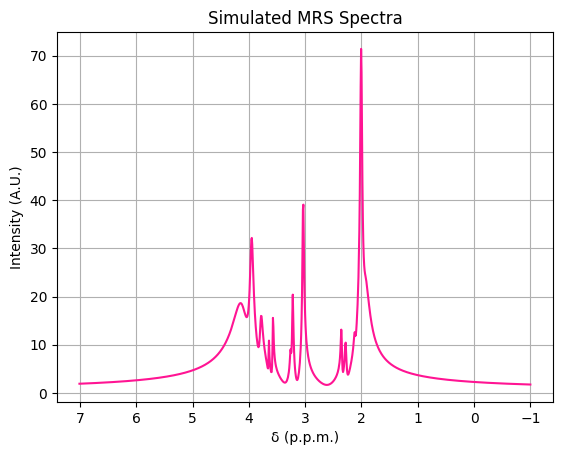

In [5]:
pop = pymri.population(ws, t2s, M_0s, spins_phi)

sig, t = pymri.population_transverse_decay(t0, tn, dt, pop, np.array([]))
freqs, sig_fft = pymri.fourier_spectrum(sig, dt, B0)
pymri.plot_chem_shifts(freqs, sig_fft, 1.0)

In [6]:
L = np.arange(start = 0.2, stop = 0.8, step = 0.05)
print(L)

[0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75 0.8 ]


In [9]:
reconstructed_sig, z, r = pymri.filter_sig( sig, 0.6, 1e-15, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True )

In [ ]:
s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)

s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)
M_0s, spins_phi, ws, t2s = np.sort(M_0s), np.sort(spins_phi), np.sort(ws), np.sort(t2s)


In [23]:
with np.printoptions(threshold=np.inf):
    print("Generated X Original")
    print("Frequencias :\t", RMSE(omega, ws))
    print("T2s :\t\t", RMSE(gen_t2, t2s))
    print("M0s : \t\t", RMSE(s0, M_0s))
    print("Fases : \t", RMSE(phi, spins_phi))

Generated X Original
Frequencias :	 2.047012614977193e-11
T2s :		 8.769156527239623e-14
M0s : 		 2.618622301126055e-14
Fases : 	 3.3274624931204597e-13


In [30]:
avgs = 10
               # (variaveis, numero de Ls, médias)
RMSEs = np.zeros((4, L.size, avgs))

In [ ]:
for i in range(L.size):
    for j in range(avgs):
        reconstructed_sig, z, r = pymri.filter_sig( sig, L[i], 1e-15, rcond=rcond, zero_filtering=zero_filtering, return_poles_and_res=True )

        s0, phi, omega, alpha = pymri.calculate_variables_from_z_and_r(z, r, dt)
        s0, phi, omega, gen_t2 = np.sort(s0), np.sort(phi), np.sort(omega), np.sort(1/alpha)

        RMSEs[0, i, j] = RMSE(omega, ws)
        RMSEs[1, i, j] = RMSE(gen_t2, t2s)
        RMSEs[2, i, j] = RMSE(s0, M_0s)
        RMSEs[3, i, j] = RMSE(phi, spins_phi)

In [38]:
avg_RMSEs = np.average(RMSEs, axis = 2)
std_RMSEs = np.std(RMSEs, axis=2)

print(std_RMSEs)

[[0.00000000e+00 4.03896783e-28 0.00000000e+00 6.46234854e-27
  0.00000000e+00 0.00000000e+00 3.23117427e-27 3.23117427e-27
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  8.07793567e-28]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.15544362e-30
  0.00000000e+00 6.31088724e-30 6.31088724e-30 0.00000000e+00
  1.26217745e-29 0.00000000e+00 0.00000000e+00 6.31088724e-30
  0.00000000e+00]
 [6.31088724e-30 0.00000000e+00 1.26217745e-29 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.31088724e-30
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00974196e-28
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]


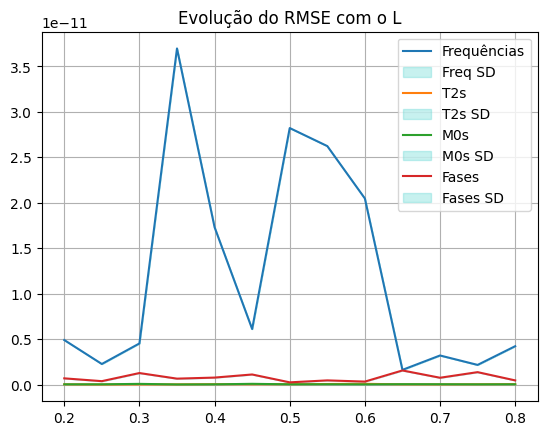

In [40]:
plt.plot(L, avg_RMSEs[0], label = "Frequências")
plt.fill_between(L, avg_RMSEs[0] - std_RMSEs[0], avg_RMSEs[0] + std_RMSEs[0], alpha = 0.3, color = "mediumturquoise", label = "Freq SD")
plt.plot(L, avg_RMSEs[1], label = "T2s")
plt.fill_between(L, avg_RMSEs[1] - std_RMSEs[1], avg_RMSEs[1] + std_RMSEs[1], alpha = 0.3, color = "mediumturquoise", label = "T2s SD")
plt.plot(L, avg_RMSEs[2], label = "M0s")
plt.fill_between(L, avg_RMSEs[2] - std_RMSEs[2], avg_RMSEs[2] + std_RMSEs[2], alpha = 0.3, color = "mediumturquoise", label = "M0s SD")
plt.plot(L, avg_RMSEs[3], label = "Fases")
plt.fill_between(L, avg_RMSEs[3] - std_RMSEs[3], avg_RMSEs[3] + std_RMSEs[3], alpha = 0.3, color = "mediumturquoise", label = "Fases SD")
plt.title("Evolução do RMSE com o L")
plt.grid()
plt.legend()